In [2]:
!pip install xgboost



  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/99/19/e2544328cb7be70d7f73a7660ecce3a63b40282ff1a344c44c2faeef9586/xgboost-3.0.4-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 660.6 kB/s eta 0:01:26
   ---------------------------------------- 0.1/56.8 MB 812.7 kB/s eta 0:01:10
   ---------------------------------------- 0.1/56.8 MB 1.1 MB/s eta 0:00:53
   ---------------------------------------- 0.2/56.8 MB 952.6 kB/s eta 0:01:00
   ---------------------------------------- 0.2/56.8 MB 958.4 kB/s eta 0:01:00
   ---------------------------------------- 0.3/56.8 MB 983.0 kB/s eta 0:00:58
   ---------------------------------------- 0.3/56.8 MB 999.9 kB/s eta 0:00:57
   ---------------------------------------- 0.4/56.8 MB 1.0 MB/s eta 0:00:55
   ---------------------------------------- 0.4/56.8 MB 1.1 MB/s eta 0:00:54
   -----------------

In [2]:
# Install required libraries (if not already installed):
# pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
# 1. Load Dataset

# Download from: https://www.kaggle.com/blastchar/telco-customer-churn
df = pd.read_csv(r"C:\Users\email\Downloads\Customer Churn Prediction\Telco-Customer-Churn.csv")

print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

In [4]:
'''
print("Raw dataset shape:", df.shape)
print(df.head())
print(df.columns)


Raw dataset shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Stream

In [6]:
# ---------------------------
# 2. Preprocessing
# ---------------------------

# Debugging Step 1: check raw shape
print("Raw dataset shape:", df.shape)

# --- 2.1 Drop customerID (not useful for prediction)
# Drop customerID (if present, otherwise ignore)
df = df.drop("customerID", axis=1, errors="ignore")
print("After dropping customerID -> Shape:", df.shape)


# --- 2.2 Convert TotalCharges to numeric (coerce errors to NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# --- 2.3 Check NaNs after conversion
print("After converting TotalCharges -> NaNs:", df["TotalCharges"].isna().sum())

# --- 2.4 Fill missing TotalCharges with median (✅ safer reassignment)
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
print("After filling NaNs -> Remaining NaNs:", df.isna().sum().sum())

# --- 2.5 Separate target variable
y = df["Churn"].map({"Yes": 1, "No": 0})  # encode target
X = df.drop("Churn", axis=1)
print("After separating target -> X shape:", X.shape, "| y shape:", y.shape)

# --- 2.6 Encode categorical features
cat_features = X.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X, columns=cat_features, drop_first=True)
print("After encoding categoricals -> X shape:", X.shape)

# --- 2.7 Standardize numeric features
from sklearn.preprocessing import StandardScaler

num_features = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
print("After scaling numerics -> X shape:", X.shape)



Raw dataset shape: (7043, 21)
After dropping customerID -> Shape: (7043, 20)
After converting TotalCharges -> NaNs: 11
After filling NaNs -> Remaining NaNs: 0
After separating target -> X shape: (7043, 19) | y shape: (7043,)
After encoding categoricals -> X shape: (7043, 30)
After scaling numerics -> X shape: (7043, 30)


In [7]:
# ---------------------------
# 3. Train-Test Split
# ---------------------------

# Here, we split the data => train = 80% and test = 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
# ---------------------------
# 4. Train Models
# ---------------------------

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42) # remove use_label_encoder=False atttribute cuz current versions of XGBoost don't need it
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)



📊 Random Forest Performance
Accuracy: 0.7899219304471257
ROC-AUC: 0.6956353819525175
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



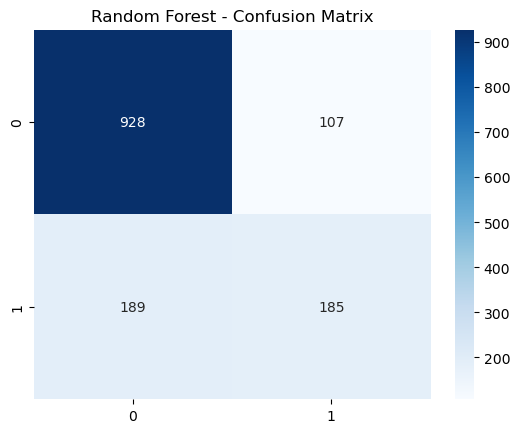


📊 XGBoost Performance
Accuracy: 0.7849538679914834
ROC-AUC: 0.7050608385646748
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



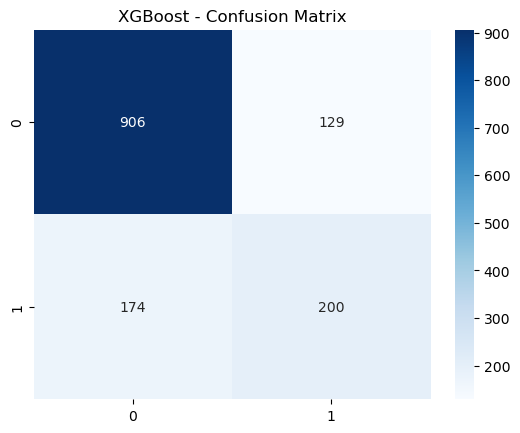

In [9]:
# ---------------------------
# 5. Evaluation
# ---------------------------

# Define a function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    # Print model name for clarity
    print(f"\n📊 {model_name} Performance")
    
    # Print accuracy score (overall correct predictions / total predictions)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    
    # Print ROC-AUC score (how well the model separates churn vs. non-churn)
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    
    # Print classification report (precision, recall, f1-score, support for each class)
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    # Plot confusion matrix as a heatmap for better visualization
    sns.heatmap(
        confusion_matrix(y_true, y_pred),  # Compute confusion matrix
        annot=True,                        # Show numbers inside the cells
        fmt="d",                           # Format as integers
        cmap="Blues"                       # Color scheme (blue shades)
    )
    
    # Add a title with the model name
    plt.title(f"{model_name} - Confusion Matrix")
    
    # Display the heatmap
    plt.show()


# Evaluate Random Forest predictions
evaluate_model(y_test, rf_pred, "Random Forest")

# Evaluate XGBoost predictions
evaluate_model(y_test, xgb_pred, "XGBoost")


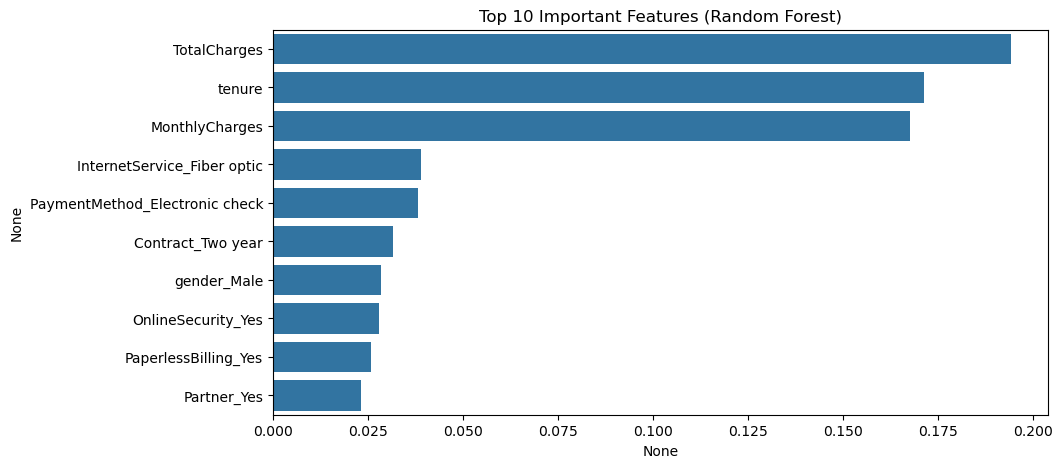

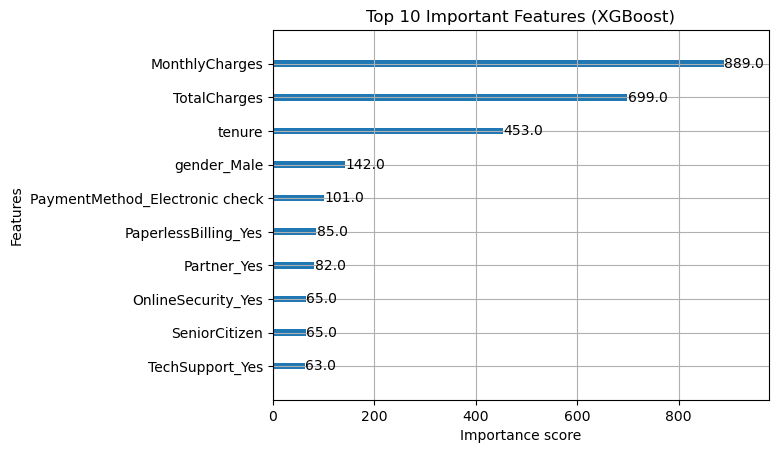

In [10]:
# ---------------------------
# 6. Feature Importance
# ---------------------------

# 📌 Random Forest Feature Importance

# Get feature importance scores from the trained Random Forest model
# rf.feature_importances_ -> gives importance score for each feature
# pd.Series(..., index=X.columns) -> converts to Series with feature names
# .sort_values(ascending=False) -> sorts from most to least important
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Create a figure with width=10 and height=5
plt.figure(figsize=(10,5))

# Plot the top 10 most important features as a bar chart
# x -> importance values, y -> feature names
sns.barplot(x=rf_importances[:10], y=rf_importances.index[:10])

# Add title and display plot
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


# 📌 XGBoost Feature Importance

# Plot feature importance using XGBoost's built-in method
# max_num_features=10 -> show only top 10
# importance_type="weight" -> importance is based on how often the feature is used in splits
xgb.plot_importance(xgb_model, max_num_features=10, importance_type="weight")

# Add title and display plot
plt.title("Top 10 Important Features (XGBoost)")
plt.show()


In [11]:
# ---------------------------
#  Conclusion
# ---------------------------

# In this project, we built machine learning models (Random Forest and XGBoost)
# to predict customer churn using the Telco Customer Churn dataset.  
#
# After preprocessing the data and training the models, both achieved good accuracy 
# and ROC-AUC scores.  
#
# The most important factors affecting churn were:  
# - Contract type  
# - Tenure  
# - Payment method  
# - Monthly charges  
# - Internet service  
#
# These insights show that telecom companies can use such models to identify customers 
# who are likely to leave and take steps to retain them.  
#
#  Key takeaway: Machine learning helps reduce churn and improve customer satisfaction 
# by predicting at-risk customers in advance.
